In [1]:
from pathlib import Path
import datetime
import traceback
import pathlib

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
from dask.distributed import Client, performance_report
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import PackedSelection
from coffea import dataset_tools

from functools import partial
import os
import time
import warnings

import cowtools

import utils  # worker count tracking

executor = "dask"   # "dask" or "taskvine" or "dask_gateway"

warnings.filterwarnings("ignore")
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here

# create a folder for output tracking of uproot.open setup
MEASUREMENT_PATH = pathlib.Path(datetime.datetime.now().strftime("measurements/%Y-%m-%d_%H-%M-%S"))
os.makedirs(MEASUREMENT_PATH)
    
print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


awkward: 2.8.2
dask-awkward: 2025.5.0
uproot: 5.6.1
hist: 2.8.0
coffea: 2025.3.0


In [2]:
scheduler_options = {}

# for coffea-casa
if executor == "taskvine":
    from ndcctools.taskvine import DaskVine, Task
    
    
    manager = DaskVine(port=8786, ssl=True, name=f"{os.environ.get('USER', 'noname')}-coffea-casa")

    extra_files = {}
    env_vars = {}
    
    token_acc_path = "/etc/cmsaf-secrets-chown/access_token"
    token_xch_path = "/etc/cmsaf-secrets-chown/xcache_token"

    if Path(token_acc_path).is_file():
        extra_files[manager.declare_file(token_acc_path, cache=True)] = "access_token"
        env_vars["BEARER_TOKEN_FILE"] = "access_token"
    if Path(token_xch_path).is_file():
        extra_files[manager.declare_file(token_xch_path, cache=True)] = "xcache_token"
        env_vars["XCACHE_FILE"] = "xcache_token"

    vine_scheduler = partial(manager.get,
                             resources={"cores": 1, "disk": 2000},  #  max 1 core, 5GB of disk per task
                             extra_files=extra_files,
                             env_vars=env_vars,
                             submit_per_cycle=1000,
                             lazy_transfers=True,
                             #  resources_mode=None,   # set to "fixed" to kill tasks on resources
                            )
    # change default scheduler
    scheduler_options['scheduler'] = vine_scheduler
elif executor == "dask_gateway":
    num_workers = 100   #number of workers desired
    from dask.distributed import LocalCluster, Client, progress
    from dask_gateway import Gateway
    import pathlib
    
    gateway = Gateway()
    clusters=gateway.list_clusters()
    cluster = gateway.connect(clusters[0].name)
    client = cluster.get_client()
    cluster.scale(num_workers)
    # %%
    def set_env(dask_worker):
        path = str(pathlib.Path(dask_worker.local_directory) / 'access_token')
        os.environ["BEARER_TOKEN_FILE"] = path
        os.chmod(path, 0o600)
        os.chmod("/etc/grid-security/certificates", 0o755)

    client.wait_for_workers(num_workers)
    client.upload_file("/etc/cmsaf-secrets/access_token")
    client.run(set_env)
        
else:
    # by default use dask   
    # local: single thread, single worker
    from dask.distributed import LocalCluster, Client, progress
    
    # cluster = LocalCluster(n_workers=1, processes=False, threads_per_worker=1)
    # client = Client(cluster)
    #client = Client("tls://localhost:8786")
    client = cowtools.GetCondorClient(max_workers=100, memory="4 GB")
    
client

dask workers will run in /cvmfs/unpacked.cern.ch/registry.hub.docker.com/coffeateam/coffea-dask-almalinux9:2025.3.0-py3.12
Condor logs, output files, error files in /scratch/rsimeon


Connection method: Cluster object,Cluster type: dask_jobqueue.HTCondorCluster
Dashboard: proxy/25457/status,
Dashboard: proxy/25457/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://144.92.181.248:20361,Workers: 0
Dashboard: proxy/25457/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
import json
fname = "zstd_files.json"
fileset = {}
with open(fname,'r') as fp:
    for i,(dataset_name,file_list) in enumerate(json.load(fp).items()):
        fileset[dataset_name] = {"files": {}}
        for j,dataset_fpath in enumerate(file_list):
            xrd_fpath = f"root://cmsxcache.hep.wisc.edu/{dataset_fpath}"
            fileset[dataset_name]["files"][xrd_fpath] = "Events"

In [4]:
# apply optional filtering to limit number of input files

# limite to the first N files per container, None if no limit
LIMIT_NUM_FILES = None

# limit to the first N containers, None if no limit
LIMIT_NUM_CONTAINERS = 2

fileset = coffea.dataset_tools.max_files(fileset, LIMIT_NUM_FILES)

if LIMIT_NUM_CONTAINERS is not None:
    fileset = dict((k,v) for i, (k,v) in enumerate(fileset.items()) if i <LIMIT_NUM_CONTAINERS)

print(f"number of input files after filter: {sum([len(f['files']) for f in fileset.values()])}")
utils.worker_tracking.save_fileset(fileset, MEASUREMENT_PATH)

number of input files after filter: 1875


In [5]:
# turn fileset into simple list of files to run over
all_files = []
for process in fileset:
    all_files += fileset[process]["files"]

# define work to be done
def uproot_open_materialize(fname):
    BRANCH_LIST = [
        "GenPart_pt", "GenPart_eta", "GenPart_phi", "CorrT1METJet_phi",
        "GenJet_pt", "CorrT1METJet_eta", "SoftActivityJet_pt",
        "Jet_eta", "Jet_phi", "SoftActivityJet_eta", "SoftActivityJet_phi", 
        "CorrT1METJet_rawPt", "Jet_btagDeepFlavB", "GenJet_eta", 
        "GenPart_mass", "GenJet_phi",
        "Jet_puIdDisc", "CorrT1METJet_muonSubtrFactor", "Jet_btagDeepFlavCvL",
        "Jet_btagDeepFlavQG", "Jet_mass", "Jet_pt", "GenPart_pdgId",
        "Jet_btagDeepFlavCvB", "Jet_cRegCorr"
        ]

    filter_name = lambda x: x in BRANCH_LIST

    size_uncompressed = 0
    t0 = time.perf_counter()
    try:
        with uproot.open(fname, filter_name=filter_name) as f:
            num_entries = f["Events"].num_entries
            for b in BRANCH_LIST:
                f["Events"][b].array()
                size_uncompressed += f["Events"][b].uncompressed_bytes

            size_read = f.file.source.num_requested_bytes
        exception = None

    except:
        num_entries = 0
        size_read = 0
        size_uncompressed = 0
        exception = traceback.format_exc()

    t1 = time.perf_counter()
    time_finished = datetime.datetime.now()
    return {"fname": fname, "read": size_read, "uncompressed": size_uncompressed, "num_entries": num_entries,
            "runtime": t1-t0, "time_finished": time_finished, "exception": exception}

In [6]:
# perform computation
print(f"running with {len(all_files)} files")
# scattered_data = client.scatter([f for f in all_files])  # instead of submitting (possibly big) object directly

utils.worker_tracking.start_tracking_workers(client, MEASUREMENT_PATH)  # track worker count in background
t0 = time.perf_counter()
with performance_report(filename=MEASUREMENT_PATH/"dask-report-plain-uproot.html"):
    # futures = client.map(uproot_open_materialize, scattered_data)
    # out = ak.Array([r for r in client.gather(iter(futures))])
    tasks = [dask.delayed(uproot_open_materialize)(f) for f in all_files]
    out = ak.Array(dask.compute(*tasks))
t1 = time.perf_counter()
utils.worker_tracking.stop_tracking_workers()

print(f"wall clock time: {t1-t0:.2f}s")
utils.worker_tracking.save_measurement(out, t0, t1, MEASUREMENT_PATH)

running with 1875 files
sleeping for two seconds before proceeding to ensure tracking is done
wall clock time: 1500.98s


In [7]:
client.shutdown()

In [8]:
# load measurements from file again
timestamps, nworkers, avg_num_workers = utils.worker_tracking.get_timestamps_and_counts(MEASUREMENT_PATH)  # worker count info
out, t0, t1 = utils.worker_tracking.load_measurement(MEASUREMENT_PATH)

# summary of performance
read_GB = sum(out['read']) / 1000**3
print(f"total read (compressed): {read_GB:.2f} GB")
print(f"total read (uncompressed): {sum(out['uncompressed']) / 1000**3:.2f} GB")

rate_Gbps = read_GB*8/(t1-t0)
print(f"average data rate: {rate_Gbps:.2f} Gbps (need to scale by x{200/rate_Gbps:.1f} to reach 200 Gbps)")

n_evts = sum(out["num_entries"])
print(f"total event rate (wall clock time): {n_evts / (t1-t0) / 1000:.2f} kHz (processed {n_evts} events total)")

total_runtime = sum(out["runtime"])
print(f"total aggregated runtime in function: {total_runtime:.2f} s")
print(f"ratio total runtime / wall clock time: {total_runtime / (t1-t0):.2f} "\
      "(should match # cores without overhead / scheduling issues)")
print(f"time-averaged number of workers: {avg_num_workers:.1f}")
print(f"\"efficiency\" (ratio of two numbers above): {total_runtime / (t1-t0) / avg_num_workers:.1%}")
print(f"event rate (aggregated time spent in function): {n_evts / total_runtime / 1000:.2f} kHz")

total read (compressed): 1013.54 GB
total read (uncompressed): 2359.23 GB
average data rate: 5.40 Gbps (need to scale by x37.0 to reach 200 Gbps)
total event rate (wall clock time): 593.16 kHz (processed 890329821 events total)
total aggregated runtime in function: 136412.39 s
ratio total runtime / wall clock time: 90.88 (should match # cores without overhead / scheduling issues)
time-averaged number of workers: 90.4
"efficiency" (ratio of two numbers above): 100.5%
event rate (aggregated time spent in function): 6.53 kHz


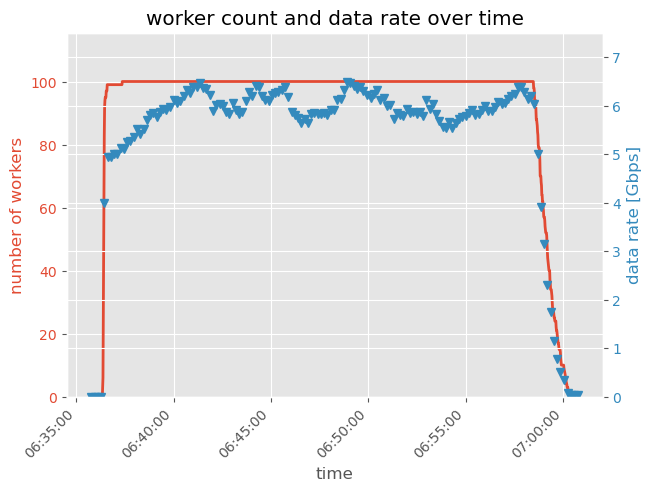

In [9]:
# get arrays for starting time, runtime and end time of all tasks
runtimes = np.asarray([datetime.timedelta(seconds=t) for t in out["runtime"]], dtype=np.timedelta64)
ends = out["time_finished"].to_numpy()
starts = ends - runtimes

# calculate instantaneous rates for given timestamp
times_for_rates = []
instantaneous_rates = []
for t in timestamps[::10]:  # only calculate every 30 seconds
    mask = np.logical_and((starts <= t), (t <= ends))  # mask for tasks running at given timestamp
    rate_Gbps_at_timestamp = sum(out[mask]['read']*8 / 1000**3 / out[mask]["runtime"])
    times_for_rates.append(t)
    instantaneous_rates.append(rate_Gbps_at_timestamp)

utils.worker_tracking.plot_worker_count(timestamps, nworkers, avg_num_workers, times_for_rates, instantaneous_rates, MEASUREMENT_PATH)

In [10]:
print(f"{sum(o is not None for o in out['exception'])} files failed\n")

# use below to get full list with details
for report in out:
    if report["exception"] is not None:
        print(f"{report['fname']} failed in {report['runtime']:.2f} s\n{report['exception']}\n")

60 files failed

root://cmsxcache.hep.wisc.edu//store/user/IDAP/RunIISummer20UL18NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/40000/E706A7C7-9CA9-704A-BF24-9D8369DFB7ED.root failed in 125.12 s
Traceback (most recent call last):
  File "/tmp/ipykernel_1647097/1925704852.py", line 24, in uproot_open_materialize
  File "/usr/local/lib/python3.12/site-packages/uproot/reading.py", line 142, in open
    file = ReadOnlyFile(
           ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/uproot/reading.py", line 561, in __init__
    self._source = source_cls(file_path, **self._options)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/uproot/source/fsspec.py", line 45, in __init__
    self._open()
  File "/usr/local/lib/python3.12/site-packages/uproot/source/fsspec.py", line 59, in _open
    self._file = self._fs.open(self._file_path)
                 ^^^

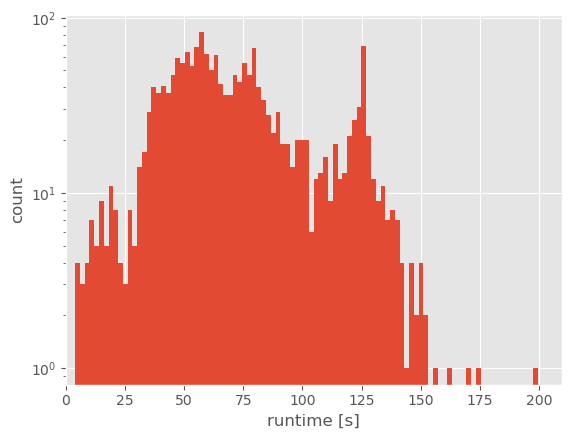

In [11]:
# runtime distribution for all files
fig, ax = plt.subplots() 
bins = np.linspace(0, max(out["runtime"])*1.01, 100)
ax.hist(out["runtime"], bins=bins)
ax.set_xlabel("runtime [s]")
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylabel("count")
ax.semilogy()
fig.savefig(MEASUREMENT_PATH / "runtime_distribution.pdf")

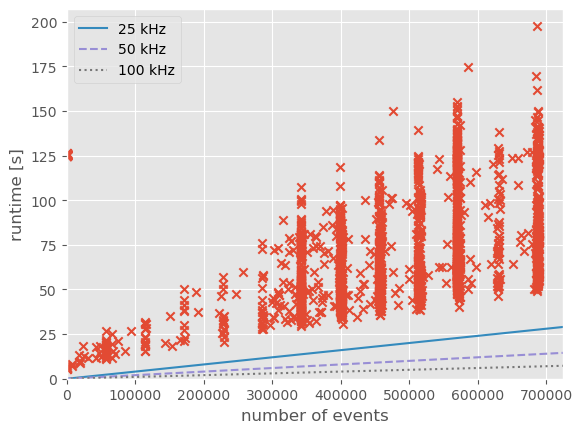

In [12]:
# runtime vs number of events in file
fig, ax = plt.subplots()
ax.scatter(out["num_entries"], out["runtime"], marker="x")
ax.set_xlabel("number of events")
ax.set_ylabel("runtime [s]")

xlim = ax.get_xlim()
ylim = ax.get_ylim()
xvals = np.linspace(*xlim, 100)
ax.plot(xvals, xvals/(25*1_000), label="25 kHz", linestyle="-", c="C1")
ax.plot(xvals, xvals/(50*1_000), label="50 kHz", linestyle="--", c="C2")
ax.plot(xvals, xvals/(100*1_000), label="100 kHz", linestyle=":", c="C3")
ax.set_xlim([0, xlim[1]])
ax.set_ylim([0, ylim[1]])
ax.legend()

fig.savefig(MEASUREMENT_PATH / "runtime_vs_nevts.pdf")

# below: coffea 2024 approach

In [ ]:
def task(events):
    # track number of events
    num_events = ak.num(events, axis=0)

    # read out all other branches into integers to avoid memory issues
    _counter = 0
    for obj_to_add in [
        events.GenPart.pt,
        events.GenPart.eta,
        events.GenPart.phi,
        events.CorrT1METJet.phi,
        events.GenJet.pt, 
        events.CorrT1METJet.eta,
        events.SoftActivityJet.pt,
        events.Jet.eta,
        events.Jet.phi,
        events.SoftActivityJet.eta,
        events.SoftActivityJet.phi, 
        events.CorrT1METJet.rawPt,
        events.Jet.btagDeepFlavB,
        events.GenJet.eta, 
        events.GenPart.mass,
        events.GenJet.phi,
        events.Jet.puIdDisc,
        events.CorrT1METJet.muonSubtrFactor,
        events.Jet.btagDeepFlavCvL,
        events.Jet.btagDeepFlavQG,
        events.Jet.mass,
        events.Jet.pt,
        events.GenPart.pdgId,
        events.Jet.btagDeepFlavCvB,
        events.Jet.cRegCorr
        
    ]:
        _counter_to_add = ak.count_nonzero(obj_to_add, axis=1)

        # reduce >2-dimensional (per event) branches further
        for _ in range(_counter_to_add.ndim - 1):
            _counter_to_add = ak.count_nonzero(_counter_to_add, axis=-1)

        _counter = _counter + _counter_to_add  # sum 1-dim array built from new branch

    _counter = ak.count_nonzero(_counter, axis=0)  # reduce to int

    return {"nevts": num_events, "_counter": _counter}

In [ ]:
%%time
# pre-process
samples, report = dataset_tools.preprocess(fileset, skip_bad_files=True, uproot_options={"allow_read_errors_with_report": True}, **scheduler_options)

In [ ]:
# find issues where access did not work
for process in report:
    for k, v in report[process]["files"].items():
        if v["steps"] is None:
            print(f"could not read {k}")

In [ ]:
%%time
# create the task graph
tasks = dataset_tools.apply_to_fileset(task, samples, uproot_options={"allow_read_errors_with_report": (OSError, TypeError, KeyError)})

execute task graph

In [ ]:
%%time
# execute
utils.worker_tracking.start_tracking_workers(client, MEASUREMENT_PATH)  # track worker count in background
t0 = time.perf_counter()

if executor == "taskvine":
    ((out, report),) = dask.compute(tasks, **scheduler_options)
else:
    with performance_report(filename=MEASUREMENT_PATH/"dask-report.html"):
        ((out, report),) = dask.compute(tasks, **scheduler_options)  # feels strange that this is a tuple-of-tuple
t1 = time.perf_counter()
utils.worker_tracking.stop_tracking_workers()

time_uproot = ak.sum([v['duration'] for v in report.values()])
print(f"total time spent in uproot reading data: {time_uproot:.2f} s")
print(f"wall time: {t1-t0:.2f}s")

timestamps, nworkers, avg_num_workers = utils.worker_tracking.get_timestamps_and_counts(MEASUREMENT_PATH)  # worker count info

In [ ]:
print(f"output: {out}")

print("\nperformance metrics:")
event_rate = sum([out[process]["nevts"] for process in out.keys()]) / (t1-t0)
print(f" - event rate: {event_rate / 1_000:.2f} kHz")

# need uproot>=5.3.2 to get these useful performance stats
num_bytes = ak.sum([report[process]["performance_counters"]["num_requested_bytes"] for process in out.keys()])
read_MB = num_bytes / 1_000**2
rate_Mbs = read_MB / (t1-t0)
print(f" - read {read_MB:.2f} MB in {t1-t0:.2f} s -> {rate_Mbs*8:.2f} Mbps (need to scale by x{200/8/rate_Mbs*1000:.0f} to reach 200 Gbps)")
print(f" - time-averaged number of workers: {avg_num_workers:.1f}")
print(f" - spent {time_uproot:.1f} s reading data with wall time {t1-t0:.2f} and {avg_num_workers:.1f} cores on average -> \"efficiency\": {time_uproot / (t1-t0) / avg_num_workers:.1%}")

utils.worker_tracking.plot_worker_count(timestamps, nworkers, avg_num_workers, [], [], pathlib.Path("."))

In [ ]:
# report problematic files that caused exceptions
for process in report.keys():
    for i_file in range(len(report[process].exception)):
        file_report = report[process][i_file]
        if file_report.exception is not None:
            print(file_report.args[0].strip("\'"))
            print(file_report.message + "\n")